In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

In [5]:
# define class and function
class MultiLayerPerceptron(chainer.Chain):
    """Class of deep neural network(DNN) description
    
    Args:
        nodes(list of int):Nodes of network layers
        dropout(float):Dropout ratio
    """
    
    def __init__(self,nodes):
        super(MultiLayerPerceptron, self).__init__()
        self.nodes = nodes
        self.layers = len(self.nodes)
        for i in range(self.layers-1):
            self.add_link("l{}".format(i), L.Linear(self.nodes[i], self.nodes[i+1]))
            
    def __call__(self,x):
        """Return predictive values.
        
        Args:
            x([chainer]Variable):Input of DNN
        Returns:
            y([chainer]Variable):Output of DNN
        """
        y = self["l0"](x)
        for i in range(self.layers-2):
            h = F.relu(y)
            y = self["l{}".format(i+1)](h)
        return y
    
def train_test_tuple_dataset(x,y,test_ratio):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = test_ratio)
    train = chainer.datasets.TupleDataset(x_train, y_train)
    test = chainer.datasets.TupleDataset(x_test, y_test)
    return train,test
    
def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()

In [6]:
#define csv file
data_csv_file = "5411.csv"

#input columns' name
x_columns = ['Open']

#predict columns' name
y_columns = ['Close']

#network parameters
layer_number = 4
hidden_node_number = 100

#training conditions
io_normalization = True
train_data_number = 1500
epoch_number =100
batch_size = 100
optimizer = chainer.optimizers.Adam()
mylossfun = F.mean_squared_error
myaccfun = F.r2_score

gpu_device = -1 #IF you use gpu, set gpu number(e.g. gpu_device = 0)

#make data set
df = pd.read_csv(data_csv_file, sep=',')

xs = df[x_columns]
ys = df[y_columns]

if io_normalization:
    from sklearn.preprocessing import StandardScaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    xs_f = x_scaler.fit_transform(xs).astype(np.float32)
    ys_f = y_scaler.fit_transform(ys).astype(np.float32)
else:
    x_scaler = None
    y_scaler = None
    xs_f = xs.values.astype(np.float32)
    ys_f = ys.values.astype(np.float32)
    
assert train_data_number < df.shape[0]
test_ratio = 1-train_data_number/df.shape[0]
train, test = train_test_tuple_dataset(xs_f, ys_f, test_ratio)

nodes = [hidden_node_number]*layer_number
nodes[0] = len(x_columns)
nodes[-1] = len(y_columns)

In [7]:
#define multilayer perceptron network
model = L.Classifier(MultiLayerPerceptron(nodes),
                    lossfun = mylossfun,
                    accfun = myaccfun)

#setup training enviroments
optimizer.setup(model)
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle = False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device = gpu_device)
trainer = chainer.training.Trainer(updater, (epoch_number, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model, device = gpu_device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch',
                                      'iteration',
                                      'elapsed_time',
                                      'main/loss',
                                      'validation/main/loss',
                                      'main/accuracy',
                                      'validation/main/accuracy']))

#exec.training
trainer.run()

if gpu_device >= 0:
    model.to_cpu()

epoch       iteration   elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           15          0.12418       0.622469    0.0452865             0.375292       0.950881                  
2           30          0.233628      0.049267    0.0110515             0.951399       0.988115                  
3           45          0.338103      0.0104162   0.00743157            0.989556       0.99196                   
4           60          0.43901       0.00746196  0.00535288            0.992644       0.99423                   
5           75          0.546038      0.00632272  0.00473421            0.993752       0.994878                  
6           90          0.641262      0.00607932  0.00459369            0.993977       0.995041                  
7           105         0.734428      0.00611799  0.00447063            0.993747       0.995168                  
8           120         0.830897      0.00606431  0.00450336            0.99389        0.9

72          1080        8.30435       0.00592024  0.00426351            0.994168       0.995397                  
73          1095        8.4093        0.00621497  0.00469451            0.993803       0.994924                  
74          1110        8.51759       0.00627684  0.00431895            0.993586       0.995337                  
75          1125        8.61953       0.00587656  0.00443047            0.994141       0.995211                  
76          1140        8.75716       0.00617724  0.00424133            0.993852       0.99542                   
77          1155        8.88721       0.00593839  0.00455439            0.994071       0.9951                    
78          1170        8.99041       0.00618774  0.00424398            0.993942       0.995421                  
79          1185        9.10206       0.00609644  0.0042674             0.993891       0.995395                  
80          1200        9.21431       0.00587199  0.00444096            0.994115       0

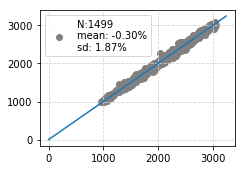

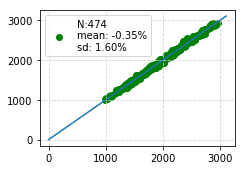

In [9]:
def myplot_aux(model, tuple_dataset, y_scaler = None):
    x = np.array([_x for _x in np.array(tuple_dataset)[:,0]])
    t = np.array([_t for _t in np.array(tuple_dataset)[:,1]])
    
    y = model(x).data
    if y_scaler is not None:
        t = y_scaler.inverse_transform(t)
        y = y_scaler.inverse_transform(y)
    return t, y
model.predictor
t, y = myplot_aux(model.predictor, train, y_scaler)
myplot(t, y, color = 'gray')
t, y = myplot_aux(model.predictor, test, y_scaler)
myplot(t, y, color='green')

try:
    y_sch = df[y_columns].values
    p_sch = df[[col + 'sch' for col in y_columns]].values
    myplot(y_sch, p_sch)
except:
    pass

plt.show()

In [12]:
print(y-t)

[[  1.71268311e+01]
 [  1.10744629e+01]
 [  7.03562012e+01]
 [  6.19448242e+01]
 [ -8.91137695e+00]
 [  1.52025146e+01]
 [  7.87219238e+00]
 [ -8.88769531e+00]
 [  4.57678223e+01]
 [ -1.21147461e+01]
 [ -4.42360840e+01]
 [  1.54851074e+01]
 [  1.47993164e+01]
 [ -1.40947266e+01]
 [  1.21237793e+01]
 [  4.40001221e+01]
 [  4.90323486e+01]
 [ -1.28554688e+01]
 [  8.93920898e+00]
 [ -3.92197266e+01]
 [ -2.26147461e+00]
 [ -1.72885742e+01]
 [ -1.07700195e+01]
 [  2.14060059e+01]
 [ -2.32480469e+01]
 [  1.15568848e+01]
 [  2.91059570e+01]
 [  3.50422363e+01]
 [ -7.68554688e+00]
 [ -9.31542969e+00]
 [ -3.33886719e+00]
 [  8.34523926e+01]
 [ -1.57106934e+01]
 [ -9.91528320e+00]
 [  8.14868164e+00]
 [ -2.84396973e+01]
 [  2.11840820e+00]
 [ -8.85690918e+01]
 [  3.04443359e-01]
 [  7.25830078e-01]
 [ -8.41232910e+01]
 [ -3.49808350e+01]
 [  4.01850586e+01]
 [ -6.47387695e+00]
 [ -3.19296875e+01]
 [ -1.15649414e+01]
 [ -1.43239746e+01]
 [  1.87126465e+01]
 [  9.02929688e+00]
 [  4.51850586e+01]
